In [106]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


In [3]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [4]:
# 2. Dataset class
class CheXpertDataset(Dataset):
    """
    Dataset for CheXpert
    Expects a CSV with columns: Path, and 14 binary label columns.
    """
    def __init__(self, img_dir, csv_file, label_cols, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_file)
        # Replace uncertain labels (-1) with 0
        self.df[label_cols] = self.df[label_cols].fillna(0).replace(-1, 0)
        self.label_cols = label_cols
        self.transform = transform or get_transforms()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['Path'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        labels = torch.tensor(row[self.label_cols].values.astype(float), dtype=torch.float32)
        return image, labels

In [5]:
def compute_pos_weights(dataset, label_cols):
    counts = torch.zeros(len(label_cols), 2)  # [neg, pos]
    for _, labels in dataset:
        for i, val in enumerate(labels):
            if val == 1:
                counts[i][1] += 1
            elif val == 0:
                counts[i][0] += 1
    pos_weights = counts[:, 0] / (counts[:, 1] + 1e-6)
    return pos_weights


In [6]:
import torch
import torch.nn as nn
from torchvision import models

def build_model(num_classes=14, freeze_until='denseblock4'):
    """
    Builds a DenseNet-121 model with the option to freeze layers up to a specified block.

    Args:
        num_classes (int): Number of output classes.
        freeze_until (str): Name of the layer up to which to freeze the model.
                            Options include 'denseblock1', 'denseblock2', 'denseblock3', 'denseblock4'.

    Returns:
        model (nn.Module): Modified DenseNet-121 model.
    """
    # Load the pretrained DenseNet-121 model
    model = models.densenet121(pretrained=True)

    # Freeze layers up to the specified block
    freeze = True
    for name, child in model.features.named_children():
        if name == freeze_until:
            freeze = False
        if freeze:
            for param in child.parameters():
                param.requires_grad = False

    # Replace the classifier to match the number of classes
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)

    return model


In [7]:
from tqdm import tqdm

In [8]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

def create_balanced_sampler(dataset, label_cols):
    # Extract labels for all samples
    labels = np.array([dataset[i][1].numpy() for i in range(len(dataset))])  # shape: (num_samples, num_classes)

    # Compute class frequencies
    class_counts = labels.sum(axis=0)  # Total count for each class
    class_weights = 1.0 / (class_counts + 1e-6)  # Avoid division by zero

    # Compute sample weights
    sample_weights = (labels * class_weights).sum(axis=1)  # Sum of class weights for each sample

    # Normalize sample weights
    sample_weights = sample_weights / sample_weights.sum()

    # Create sampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler


In [9]:
# 4. Training function

def train_tag_predictor(
    img_dir,
    csv_file,
    label_cols,
    epochs=5,
    batch_size=32,
    lr=1e-4,
    device='cuda'
):
    transform = get_transforms()
    dataset = CheXpertDataset(img_dir, csv_file, label_cols, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    model = build_model(num_classes=len(label_cols)).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.detach().cpu())
            all_preds.append(torch.sigmoid(outputs).detach().cpu())

        epoch_loss = running_loss / len(dataset)
        y_true = torch.cat(all_labels).numpy()
        y_pred = torch.cat(all_preds).numpy()
        aucs = []
        for i, col in enumerate(label_cols):
            try:
                auc = roc_auc_score(y_true[:, i], y_pred[:, i])
            except ValueError:
                auc = float('nan')
            aucs.append(auc)
        mean_auc = sum([a for a in aucs if not pd.isna(a)]) / len(label_cols)

        print(f"Epoch {epoch}/{epochs} | Loss: {epoch_loss:.4f} | Mean AUC: {mean_auc:.4f}")

    return model

In [10]:
# from sklearn.metrics import roc_auc_core, precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import DataLoader, random_split

In [20]:
def evaluate_model(y_true, y_probs, thresholds):
    """
    y_true: numpy array of shape (num_samples, num_labels)
    y_probs: numpy array of shape (num_samples, num_labels)
    thresholds: list of threshold values for each label
    """
    y_pred = np.zeros_like(y_probs)
    for i in range(y_probs.shape[1]):
        y_pred[:, i] = (y_probs[:, i] >= thresholds[i]).astype(int)

    results = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'Recall (micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'F1 Score (micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'Precision (macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1 Score (macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }

    # Optional: compute mean AUC across all labels
    aucs = []
    for i in range(y_test_true.shape[1]):
        if len(np.unique(y_test_true[:, i])) < 2:
            aucs.append(np.nan)
        else:
            aucs.append(roc_auc_score(y_test_true[:, i], y_test_pred[:, i]))
    
    results['AUC'] = np.nanmean(aucs)
    return results

In [12]:
img_dir = "/kaggle/input/chexpert"
csv_dir = "/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv"
val_ratio=0.2

In [13]:
from sklearn.metrics import f1_score

def find_best_thresholds(y_true, y_probs):
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_thresh, best_f1 = 0.5, 0
        for thresh in np.arange(0.1, 0.9, 0.05):
            f1 = f1_score(y_true[:, i], (y_probs[:, i] >= thresh).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
    return np.array(best_thresholds)

In [14]:
def apply_thresholds(y_pred, thresholds):
    return (y_pred >= thresholds).astype(int)


In [15]:
from collections import Counter
import numpy as np

def get_pos_weights(labels):
    """
    labels: numpy array of shape (num_samples, num_classes)
    """
    pos_counts = labels.sum(axis=0)
    neg_counts = labels.shape[0] - pos_counts
    weights = neg_counts / (pos_counts + 1e-6)  # to avoid division by zero
    return torch.tensor(weights, dtype=torch.float32)


In [16]:
df_train = pd.read_csv("/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv")

In [17]:
df_train.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [18]:
df_train.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [19]:
LABEL_COLS = df_train.columns[5:]

In [20]:
LABEL_COLS

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [21]:
df_train[LABEL_COLS] = df_train[LABEL_COLS].fillna(0).replace(-1, 0)

In [22]:
df_train.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
device

'cuda'

In [44]:
def evaluate_per_label(y_true, y_probs, thresholds):
    results = {}
    n_labels = y_true.shape[1]

    for i in range(n_labels):
        y_pred = (y_probs[:, i] >= thresholds[i]).astype(int)
        y_true_col = y_true[:, i]
        y_pred_col = y_pred

        results[f'Label_{i}'] = {
            'Accuracy': accuracy_score(y_true_col, y_pred_col),
            'Precision': precision_score(y_true_col, y_pred_col, zero_division=0),
            'Recall': recall_score(y_true_col, y_pred_col, zero_division=0),
            'F1 Score': f1_score(y_true_col, y_pred_col, zero_division=0),
            'AUC': roc_auc_score(y_true_col, y_probs[:, i]) if len(np.unique(y_true_col)) > 1 else float('nan')
        }

    return results


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        alpha: Tensor of shape (num_classes,) — per-class weights
        gamma: Focusing parameter for hard examples
        reduction: 'mean', 'sum', or 'none'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        inputs: logits (batch_size, num_classes)
        targets: binary labels (batch_size, num_classes)
        """
        probs = torch.sigmoid(inputs)
        targets = targets.type_as(inputs)

        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = probs * targets + (1 - probs) * (1 - targets)  # pt = p if y == 1 else 1 - p
        focal_term = (1 - pt) ** self.gamma

        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
            loss = alpha_t * focal_term * BCE_loss
        else:
            loss = focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [27]:
import matplotlib.pyplot as plt

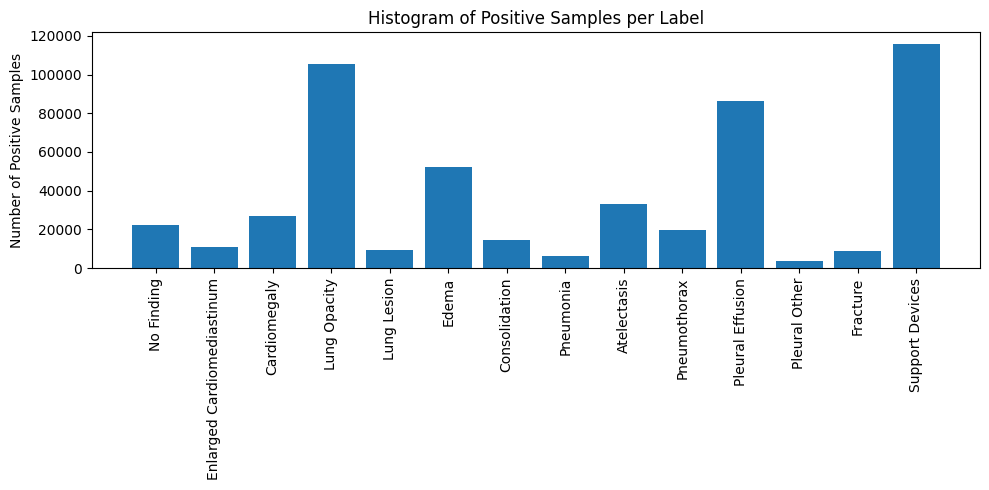

In [28]:
import numpy as np
import matplotlib.pyplot as plt

label_counts = np.sum(df_train[LABEL_COLS], axis=0)

plt.figure(figsize=(10, 5))
plt.bar(range(len(LABEL_COLS)), label_counts)
plt.xticks(range(len(LABEL_COLS)), LABEL_COLS, rotation=90)
plt.ylabel("Number of Positive Samples")
plt.title("Histogram of Positive Samples per Label")
plt.tight_layout()
plt.show()


In [29]:
label_counts

No Finding                     22381.0
Enlarged Cardiomediastinum     10798.0
Cardiomegaly                   27000.0
Lung Opacity                  105581.0
Lung Lesion                     9186.0
Edema                          52246.0
Consolidation                  14783.0
Pneumonia                       6039.0
Atelectasis                    33376.0
Pneumothorax                   19448.0
Pleural Effusion               86187.0
Pleural Other                   3523.0
Fracture                        9040.0
Support Devices               116001.0
dtype: float64

In [30]:
def get_alpha_vector(labels):
    """
    Compute alpha per class based on class frequency.
    Rare classes get higher alpha.
    """
    pos_counts = labels.sum(axis=0)
    # neg_counts = labels.shape[0] - pos_counts
    alpha = 1.0 / (pos_counts + 1e-6)  # Avoid division by zero
    alpha = alpha / alpha.sum()  # Normalize to sum to 1 (optional)
    return torch.tensor(alpha, dtype=torch.float32)


In [31]:
label_weights = 1.0 / (label_counts + 1e-6)

# Use the max weight of all labels per sample
sample_weights = []
for labels in df_train[LABEL_COLS].values:
    sample_weight = max(label_weights[labels == 1]) if labels.any() else 0.1
    sample_weights.append(sample_weight)

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [32]:
# pos_weight = get_pos_weights(train_labels).to(device)

In [33]:
transform = get_transforms()
full_dataset = CheXpertDataset(img_dir, csv_dir, LABEL_COLS, transform)

    # Compute pos_weight


    # Split into train and validation sets
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# sampler = create_balanced_sampler(train_dataset, LABEL_COLS)

train_loader = DataLoader(train_dataset, batch_size=64,shuffle = True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [35]:

all_train_labels = []

for _, labels in train_loader:
    all_train_labels.append(labels)

train_labels = torch.cat(all_train_labels, dim=0).numpy()


In [36]:
alpha = get_alpha_vector(train_labels).to(device)


In [37]:
metrics_history = {f'Label_{i}': {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'AUC': []} for i in range(len(LABEL_COLS))}


In [ ]:
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [38]:
# pos_weight = torch.Tensor([df[cl].sum()/df.shape[0] for cl in LABEL_COLS])

In [11]:
import torch.optim as optim

In [19]:
import copy
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import torch.optim as optim

def train_tag_predictor(
    img_dir,
    csv_file,
    label_cols,
    train_loader,
    val_loader,
    metrics_history,
    alpha,
    epochs=5,
    batch_size=64,
    lr=1e-4,
    device='cuda',
    early_stopping_patience=3  # new
):
    model = build_model(num_classes=len(label_cols)).to(device)
    criterion = FocalLoss(alpha=alpha, gamma=5)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_val_auc = 0.0
    best_thresholds = None
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_since_improvement = 0  # new

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.detach().cpu())
            all_preds.append(torch.sigmoid(outputs).detach().cpu())

        train_loss = running_loss / len(train_loader.dataset)
        y_train_true = torch.cat(all_labels).numpy()
        y_train_pred = torch.cat(all_preds).numpy()

        # Train AUC
        aucs = []
        for i in range(len(label_cols)):
            try:
                auc = roc_auc_score(y_train_true[:, i], y_train_pred[:, i])
            except ValueError:
                auc = float('nan')
            aucs.append(auc)
        mean_train_auc = np.nanmean(aucs)

        # Validation
        model.eval()
        val_labels = []
        val_preds = []
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Validation]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                val_labels.append(labels.cpu())
                val_preds.append(torch.sigmoid(outputs).cpu())

        val_loss = val_running_loss / len(val_loader.dataset)
        y_val_true = torch.cat(val_labels).numpy()
        y_val_pred = torch.cat(val_preds).numpy()

        # Thresholds + AUC
        current_thresholds = find_best_thresholds(y_val_true, y_val_pred)
        y_pred_bin = apply_thresholds(y_val_pred, current_thresholds)

        val_aucs = []
        for i in range(len(label_cols)):
            try:
                auc = roc_auc_score(y_val_true[:, i], y_val_pred[:, i])
            except ValueError:
                auc = float('nan')
            val_aucs.append(auc)
        mean_val_auc = np.nanmean(val_aucs)

        val_metrics = evaluate_model(y_val_true, y_val_pred, current_thresholds)

        print(f"\nEpoch {epoch}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Mean AUC: {mean_train_auc:.4f} | Val Loss: {val_loss:.4f} | Val Mean AUC: {mean_val_auc:.4f}")
        for label, metrics in val_metrics.items():
            print(f"\n{label} : {metrics}")

        # Early stopping logic
        if mean_val_auc > best_val_auc:
            print("Validation AUC improved. Saving model and thresholds.")
            best_val_auc = mean_val_auc
            best_thresholds = current_thresholds
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            print(f"No improvement in Val AUC for {epochs_since_improvement} epoch(s).")
            if epochs_since_improvement >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    print(f"\nBest Val AUC: {best_val_auc:.4f} — thresholds restored from best epoch.")

    return model, best_thresholds


In [20]:
trained_model, best_threshold_values = train_tag_predictor(
        img_dir=img_dir,
        csv_file=csv_dir,
        label_cols=LABEL_COLS,
        train_loader = train_loader,
        val_loader=val_loader,
        metrics_history = metrics_history,
        alpha= alpha, 
        epochs=7,
        batch_size=64,
        lr=1e-4,
        device=device,
    )

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/7 [Validation]: 100%|██████████| 699/699 [01:49<00:00,  6.36it/s]



Epoch 1/7
Train Loss: 0.0015 | Train Mean AUC: 0.6812 | Val Loss: 0.0014 | Val Mean AUC: 0.7289

Accuracy : 0.013472986885099144

Precision (micro) : 0.36894618086959835

Recall (micro) : 0.7525000485446319

F1 Score (micro) : 0.4951321101855165

Precision (macro) : 0.2733482181610772

Recall (macro) : 0.5506956603733043

F1 Score (macro) : 0.3479638626122087
Validation AUC improved. Saving model and thresholds.


Epoch 2/7 [Validation]: 100%|██████████| 699/699 [01:49<00:00,  6.37it/s]



Epoch 2/7
Train Loss: 0.0013 | Train Mean AUC: 0.7541 | Val Loss: 0.0013 | Val Mean AUC: 0.7416

Accuracy : 0.012868716709189383

Precision (micro) : 0.3727755973021377

Recall (micro) : 0.7598399968931435

F1 Score (micro) : 0.5001693604565702

Precision (macro) : 0.28622637532761414

Recall (macro) : 0.5609834500664934

F1 Score (macro) : 0.35486422974506343
Validation AUC improved. Saving model and thresholds.


Epoch 3/7 [Validation]: 100%|██████████| 699/699 [01:52<00:00,  6.19it/s]



Epoch 3/7
Train Loss: 0.0012 | Train Mean AUC: 0.7926 | Val Loss: 0.0014 | Val Mean AUC: 0.7443

Accuracy : 0.04057562329349626

Precision (micro) : 0.4268153991337382

Recall (micro) : 0.685023010155537

F1 Score (micro) : 0.5259368035004808

Precision (macro) : 0.3043074579456498

Recall (macro) : 0.504670787149683

F1 Score (macro) : 0.3620948410539473
Validation AUC improved. Saving model and thresholds.


Epoch 4/7 [Validation]: 100%|██████████| 699/699 [01:53<00:00,  6.16it/s]



Epoch 4/7
Train Loss: 0.0012 | Train Mean AUC: 0.8321 | Val Loss: 0.0014 | Val Mean AUC: 0.7337

Accuracy : 0.015106754397744058

Precision (micro) : 0.37143999065932587

Recall (micro) : 0.8030544282413251

F1 Score (micro) : 0.5079403095062639

Precision (macro) : 0.2730956685448005

Recall (macro) : 0.5836978988699207

F1 Score (macro) : 0.3572561976491969
No improvement in Val AUC for 1 epoch(s).


Epoch 5/7 [Validation]: 100%|██████████| 699/699 [01:51<00:00,  6.29it/s]



Epoch 5/7
Train Loss: 0.0010 | Train Mean AUC: 0.8640 | Val Loss: 0.0016 | Val Mean AUC: 0.7261

Accuracy : 0.03625621055458574

Precision (micro) : 0.41450266905988487

Recall (micro) : 0.6905668071224684

F1 Score (micro) : 0.5180521060183397

Precision (macro) : 0.2982241758515933

Recall (macro) : 0.4863894715841341

F1 Score (macro) : 0.3519022817225236
No improvement in Val AUC for 2 epoch(s).


Epoch 6/7 [Validation]: 100%|██████████| 699/699 [01:52<00:00,  6.24it/s]



Epoch 6/7
Train Loss: 0.0009 | Train Mean AUC: 0.8858 | Val Loss: 0.0019 | Val Mean AUC: 0.7198

Accuracy : 0.023678438744908464

Precision (micro) : 0.39298111096144484

Recall (micro) : 0.7364609021534398

F1 Score (micro) : 0.5124923991622187

Precision (macro) : 0.28022764320051974

Recall (macro) : 0.5153199772317884

F1 Score (macro) : 0.3490323795198833
No improvement in Val AUC for 3 epoch(s).
Early stopping triggered.

Best Val AUC: 0.7443 — thresholds restored from best epoch.


In [ ]:
# import matplotlib.pyplot as plt

# for label, metric_dict in metrics_history.items():
#     plt.figure(figsize=(12, 6))
#     for metric_name, values in metric_dict.items():
#         plt.plot(values, label=metric_name)
    
#     plt.title(f'Metrics for {label} over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Score')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(f'{label}_metrics.png')  # Save to file
#     plt.show()


In [21]:
torch.save(trained_model.state_dict(), 'chexpert_tag_best.pth')

In [24]:
import json
import os

# Save best thresholds to JSON
threshold_path = os.path.join("saved", "best_thresholds.json")
os.makedirs("saved", exist_ok=True)

with open(threshold_path, 'w') as f:
    json.dump({label: float(thresh) for label, thresh in zip(LABEL_COLS, best_threshold_values)}, f, indent=4)

print(f"Best thresholds saved to {threshold_path}")


Best thresholds saved to saved/best_thresholds.json


In [ ]:
# Load best thresholds from JSON
with open("/kaggle/working/saved/best_thresholds.json", 'r') as f:
    best_thresholds = json.load(f)

# Ensure it's a list in correct order
best_thresholds = [best_thresholds[label] for label in label_cols]


In [7]:
model = build_model(num_classes=len(LABEL_COLS)).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 195MB/s]


In [8]:
model.load_state_dict(torch.load("/kaggle/working/chexpert_tag_final.pth"))

<All keys matched successfully>

In [9]:
test_csv = "/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv"

In [10]:
transform = get_transforms()
test_dataset = CheXpertDataset(img_dir, test_csv, LABEL_COLS, transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [21]:
model.eval()
test_labels = []
test_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_labels.append(labels.cpu())
        test_preds.append(torch.sigmoid(outputs).cpu())

# Only evaluate once all batches are processed
y_test_true = torch.cat(test_labels).numpy()
y_test_pred = torch.cat(test_preds).numpy()

test_metrics = evaluate_model(y_test_true, y_test_pred, threshold)

for k, v in test_metrics.items():
    print(f"Test {k}: {v:.4f}")


Test Accuracy: 0.0641
Test Precision (micro): 0.5099
Test Recall (micro): 0.4834
Test F1 Score (micro): 0.4963
Test Precision (macro): 0.4027
Test Recall (macro): 0.3469
Test F1 Score (macro): 0.3494
Test AUC: 0.7442


In [ ]:
model = build_model(num_classes=len(LABEL_COLS)).to(device)
# model.load_state_dict(torch.load('chexpert_tag_model1.pth'))

In [ ]:
pip install -U langchain-community

In [ ]:
!pip install chroma

In [ ]:
pip install chromadb sentence-transformers

In [ ]:
df = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv")

In [ ]:

df['findings'] = df['findings'].str.replace(r'\bXXXX\b', '', regex=True).str.strip()
df['impression'] = df['impression'].str.replace(r'\bXXXX\b', '', regex=True).str.strip()


In [ ]:
df["findings"] = df["findings"].fillna("")
df["impression"] = df["impression"].fillna("")

In [ ]:
df["combined_text"] = df["findings"] + " " + df["impression"]
df["combined_text"] = df["combined_text"].astype(str)

In [ ]:
# Filter out rows where 'combined_text' is empty or contains only whitespace
df = df[df['combined_text'].str.strip() != '']


In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
embeddings = embed_model.encode(df['combined_text'].tolist())

In [ ]:
import chromadb
from chromadb.config import Settings

In [ ]:
client = chromadb.PersistentClient(path="/kaggle/working/chroma_db")
collection = client.get_or_create_collection(name = "iu_xray_report")



In [ ]:
collection.add(
    documents = df["combined_text"].tolist(),
    embeddings = embeddings,
    metadatas = [{"index":idx} for idx in df.index],
    ids = [f"doc_{idx}" for idx in df.index]
)

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings

In [ ]:
embedding_function = SentenceTransformerEmbeddings(model_name = "all-MiniLM-L6-v2")

In [ ]:
vectorstore = Chroma(
    collection_name = "iu_xray_report",
    embedding_function = embedding_function,
    persist_directory = "/kaggle/working/chroma_db"
)

In [ ]:
model.eval()

In [ ]:
from PIL import Image

img_pth = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-1001.dcm.png"

image = Image.open(img_pth).convert('RGB')
transform = get_transforms()
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension
image = image.to(device)

model.eval()
with torch.no_grad():
    output = model(image)


In [ ]:
probs = torch.sigmoid(output)
preds = (probs > 0.5).int()  

predicted_tags = [LABEL_COLS[i] for i in range(len(LABEL_COLS)) if preds[0][i] == 1]

print("Predicted Tags:", predicted_tags)


In [ ]:
preds

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("DEEPSEEKR1")


In [ ]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(
    openai_api_base="https://openrouter.ai/api/v1",
    openai_api_key=secret_value_0,
    model_name="deepseek/deepseek-chat",
    temperature=0.7
)


In [ ]:
response = llm.predict("Explain the theory of relativity.")
print(response)


In [ ]:
query = " ".join(predicted_tags)

retreived_docs = vectorstore.similarity_search(query, k=5)

In [ ]:
context = "\n\n".join([doc.page_content for doc in retreived_docs])

In [ ]:
prompt = f"""
You are a medical AI assistant. Based on the following context from previous X-ray reports:

{context}

And the following predicted tags: {', '.join(predicted_tags)}

Generate a detailed and accurate X-ray report.
"""

# Generate the report
response = llm.predict(prompt)
print(response)